In [1]:
# The Kaggle Python 3 environment comes with many helpful tools installed. 
# See the kaggle/python Docker image: https://github.com/kaggle/docker-python
# If using another environment you may need to install the packages yourself
# e.g. pip install pytorch_lightning or !pip install pytorch_lightning

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys # filesystem operations
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch import nn
import pytorch_lightning as pl
from PIL import Image
from argparse import Namespace

# When using Kaggle datasets upload of data is handled behind the scene
# Data files are available in the read-only "../input/" directory
# If you are using something else, you need to upload the data manually
# Here we take a look at the content of the input directory
input_dir = '/kaggle/input'
print(f"input dir contains: {os.listdir(input_dir)}")
dataset_dir = os.path.join(input_dir,'faces-age-detection-dataset')
print(f"dataset dir contains: {os.listdir(dataset_dir)}")
train_dir = os.path.join(dataset_dir,'Train')
print(f"train dir contains: {len(os.listdir(train_dir))} files such as {os.listdir(train_dir)[0]}")

input dir contains: ['faces-age-detection-dataset']
dataset dir contains: ['train.csv', 'Train']
train dir contains: 19906 files such as 19812.jpg


          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE

values ['MIDDLE' 'OLD' 'YOUNG']
counts [10804  2396  6706]
Image /kaggle/input/faces-age-detection-dataset/Train/24293.jpg with shape (144, 147, 3) and label MIDDLE


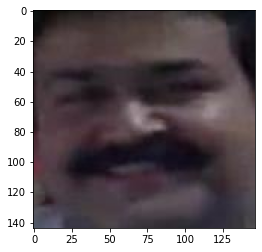

Image /kaggle/input/faces-age-detection-dataset/Train/1717.jpg with shape (460, 398, 3) and label YOUNG


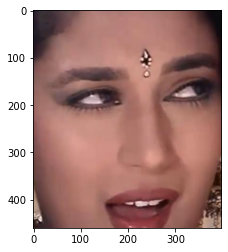

In [2]:
# Lets see what is in 'train.csv'
train_df = pd.read_csv(os.path.join(dataset_dir,'train.csv'))
print(f'{train_df.head()}\n')

# Get an overview of the labels
labels = train_df['Class'].values
values, counts = np.unique(labels, return_counts=True) # count instances for each unique label
print(f'values {values}')
print(f'counts {counts}')

# Inspect a couple of images
image_list = [os.path.join(train_dir,f) for f in train_df['ID'].values] # include the full path in the list
for _ in range(2):
    idx = random.randint(0,len(train_df))
    image = cv2.imread(image_list[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f'Image {image_list[idx]} with shape {image.shape} and label {labels[idx]}')
    plt.imshow(image)
    plt.show()

In [3]:
class AgeRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, labels, transforms=None):
        # Make sure that image_list and labels are not unequal length
        if len(image_list) != len(labels):
            raise ValueError('image_list and labels are not equal length.')
        
        self.image_list = image_list
        self.labels = labels
        self.arranged_categories = ['YOUNG', 'MIDDLE', 'OLD']
        self.transforms = transforms

    def load_sample(self, idx):
        img = Image.open(self.image_list[idx])
        label = self.arranged_categories.index(self.labels[idx])/(len(self.arranged_categories)-1) # convert categorical label to float between 0.0 and 1.0
        return img, label

    def __getitem__(self, idx):
        img, target = self.load_sample(idx)

        if self.transforms:
            img = self.transforms(img)
        else:
            img = img/255.0

        return img, torch.unsqueeze(torch.as_tensor(target),0)

    def __len__(self):
        return len(self.labels)

In [4]:
# from here: https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
    
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [5]:
# Here we define the model, optimizer, train and validation loop
class LightningRegressor(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters()

        self.lr = hparams.learning_rate
        self.model = ResNet18(image_channels=hparams.image_channels, num_classes=hparams.n_outputs)
        self.criterion = nn.MSELoss()
        self.eval_metric = nn.L1Loss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_ = self.forward(x)
        loss = self.criterion(y_, y)
        self.log('loss', loss, on_step=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_ = self.forward(x)
        loss = self.criterion(y_, y)
        mae = self.eval_metric(y_,y)
        return {'loss': loss, 'mae': mae}

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        mae = torch.stack([x['mae'] for x in outputs]).mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mae', mae, on_epoch=True)

In [6]:
hparams = Namespace(**{# data
                       'exp_name': 'mp_age_regressor', # unique name for model and logs
                       'image_size': 224, # images size for input to model
                       'image_channels': 3, # 3 for RGB, 1 for grayscale images
                       # model
                       'arch': 'resnet18', # 'resnet18',
                       'n_outputs': 1, # number of dependent variables
                       # training
                       'accelerator': 'gpu', # number of gpus
                       'max_epochs': 5, # number of times during training, where the whole dataset is traversed
                       'learning_rate': 1e-5, # generally, high means faster but worse convergence, low slow but better convergence
                       'batch_size': 32, # should be considered together with learning rate. decrease if using a small machine and getting memory errors
                       'n_workers': 2 # set to 0 in windows when working with a windows on a small machine
                       }
                    )

model_name=f"{hparams.exp_name}_{hparams.arch}_{hparams.image_size}x{hparams.image_channels}-{hparams.n_outputs}"
print("Training model: {}".format(model_name))

# prepare output directories
if not os.path.exists('logs/'):
    os.mkdir('logs/')
output_dir = os.path.join('trained_models/',model_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# The network needs the input to be a specific size and to pytorch tensors 
import torchvision.transforms as transforms
train_transforms = transforms.Compose([transforms.Resize([hparams.image_size,hparams.image_size]),
                                       transforms.ToTensor()])

train_val_set = AgeRegressionDataset(image_list=image_list, labels=labels, transforms=train_transforms) 
# since we only have the Train folder, we split its contents into training and validation set
proportions = [0.8, 0.2]
lengths = [int(p * len(train_val_set)) for p in proportions]
lengths[-1] = len(train_val_set) - sum(lengths[:-1])
train_set, val_set = torch.utils.data.random_split(train_val_set, lengths)
print(f"train_val_set of len {len(train_val_set)} split into train_set {len(train_set)} and val_set {len(val_set)}")

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, pin_memory=True, num_workers=hparams.n_workers)
val_dataloader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=False, pin_memory=True, num_workers=hparams.n_workers)

# initialize model, training and validation code
lightning_module = LightningRegressor(hparams)

# initialize training
from pytorch_lightning import Trainer
trainer = pl.Trainer(accelerator=hparams.accelerator, 
                     max_epochs=hparams.max_epochs,
                     precision=16, # faster processing on most GPUs, smaller memory use
                     benchmark=True, # use cuda optimizations specific to your network
                     #accumulate_grad_batches=4,# trick to get larger effective batch size
                     #limit_train_batches=0.05, # only use a fraction of batches (faster epochs)
                     #limit_val_batches=0.05
                     )

Training model: mp_age_regressor_resnet18_224x3-1
train_val_set of len 19906 split into train_set 15924 and val_set 3982


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# train model, takes a while
trainer.fit(lightning_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

predicting 1 by 1 from test(val) set of size  3982
done with  0
done with  100
done with  200
done with  300
done with  400
done with  500


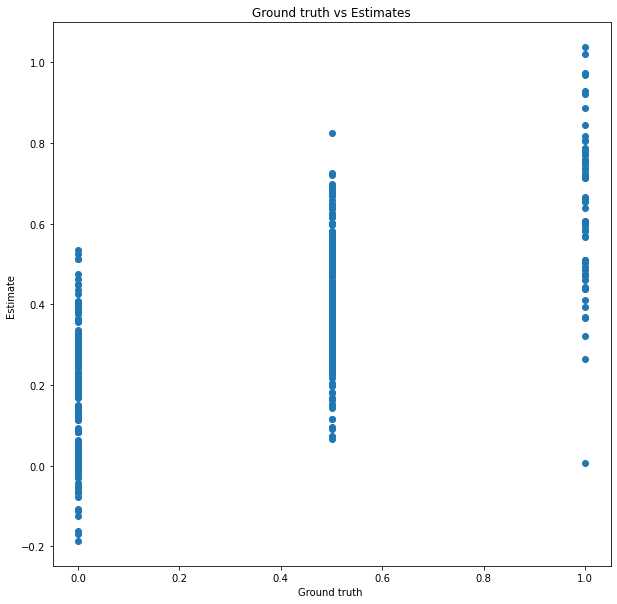

In [8]:
# TODO: predict on gpu and in batches
predictor = lightning_module.model.eval().cpu()
test_set = val_set

print("predicting 1 by 1 from test(val) set of size ", len(test_set))
labels, predictions = [], []
for i in range(len(test_set)):
    img, label = test_set[i]
    labels.append(label.numpy())
    with torch.no_grad():
        pred = predictor(torch.unsqueeze(img, 0))[0].cpu().numpy()
        predictions.append(pred)
    if i % 100 == 0:
        print("done with ", i)
    if i > 500: # stop after the first 500 to speed things up
        break
        
def plot_results(labels, predictions, unit=''):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    vmin, vmax = np.min(labels), np.max(labels)
    sc0 = ax.scatter(x=labels, y=predictions, vmin=vmin, vmax=vmax)
    ax.set(xlabel=f"Ground truth {unit}", ylabel=f"Estimate {unit}")
    ax.title.set_text('Ground truth vs Estimates')
    plt.show()

plot_results(labels, predictions)